In [1]:
import sys
import os

# Add the parent folder to the module search path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import colorcet as cc
from src import numberfun as nf
from src import numberdata as nd

# Load the sequence data
nd.load_pseudos()
nd.load_primitives()

In [2]:
def perfection_data_builder(
    filename: str,
    data_type: str = "list",
    mode: str = "n",
    stop: int | bool = False,
    primitive_only: bool = True,
    optimise: bool = True,
    interpolate: bool = False,
) -> dict | list | None:
    """
    Builds a list or dictionary of perfection entropies for a range of numbers or loads all values from a file.

    Args:
        filename (str): Name of the file to save to or load from.
        data_type (str): 'dict' or 'list'.
        mode (str): 'n' for new data, 'e' for extending loaded data. Default is 'n'.
        stop (int | bool): Number of values to calculate. Must be a positive integer.
        primitive_only (bool): True loads primitive pseudo-perfect numbers only, False loads all pseudo-perfect numbers.
        optimise (bool): True for optimized calculations, False for all partitions.
        interpolate (bool): True to calculate missing values between loaded data. 

    Returns:
        dict | list | None: Perfection entropies for the range of numbers or None if filename is invalid.
    """

    if mode == 'l': # Load only
        return nd.load_entropies_data(data_type, filename)

    if not isinstance(stop, int) or stop <= 0:
        raise ValueError("The 'stop' parameter must be a positive integer.")

    if mode == 'e': # Extend loaded data
        perfection_entropies, start = extend_data(filename, data_type)
        if interpolate and primitive_only:
            print("Interpolation requires all pseudo-perfect numbers to be loaded, please set 'primitive_only' to False.")
            return None
    elif mode == 'n': # New data
        start = 0
        interpolate = False # Interpolation not possible for new data
        if data_type == 'dict':
            perfection_entropies = {}
            filename = nd.check_filename(filename, 'json')
        else:
            perfection_entropies = []
            filename = nd.check_filename(filename, 'txt')
        if filename == None:
            return None
    if interpolate:
        start = 0
    stop = start + stop

    if primitive_only:
        source = nd.PRIMITIVES[start:stop]
    else:
        source = nd.PSEUDOS[start:stop]

    yield_values(
        perfection_entropies, filename, data_type, source, optimise, interpolate)
    return perfection_entropies


def yield_values(
    perfection_entropies: dict | list,
    filename: str,
    data_type: str,
    source: list | range,
    optimise: bool,
    interpolate: bool,
) -> dict | list:
    """
    Yields perfection entropies for a range of numbers and saves them to a file.

    Args:
        perfection_entropies (dict | list): Existing perfection entropies data.
        filename (str): Name of the file to save data to.
        data_type (str): 'dict' or 'list'.
        source (iterable): Range of numbers to calculate perfection entropies for.
        optimise (bool): True for optimized calculations, False for all combinations.
        interpolate (bool): True to calculate missing values between loaded data.

    Returns:
        dict | list: Updated perfection entropies data.
    """
    if data_type == 'dict':
        ext = 'json'
        for result in yield_range(source, data_type, perfection_entropies, optimise, interpolate):
            perfection_entropies[result[0]] = result[1]
            nd.save_data(result, filename, data_type)
    else:
        ext = 'txt'  
        for result in yield_range(source, data_type, perfection_entropies, optimise, interpolate):
            perfection_entropies.append(result)
            nd.save_data(result, filename, data_type)
    print(f"File saved to ./{filename}.{ext}")
    return perfection_entropies


def yield_range(
    source: list | range,
    data_type: str,
    perfection_entropies: dict | list,
    optimise: bool,
    interpolate: bool,
) -> iter:
    """
    Calculates perfection entropies for a range of numbers.

    Args:
        source (iterable): Range of numbers to calculate perfection entropies for.
        data_type (str): 'dict' or 'list'.
        perfection_entropies (dict | list): Existing perfection entropies data.
        optimise (bool): True for optimized calculations, False for all partitions.
        interpolate (bool): True to calculate missing values between loaded data.

    Returns:
        generator: Generator yielding calculated perfection entropies.
    """
    if data_type == 'dict':
        return yield_dict_range(source, perfection_entropies, optimise, interpolate)
    else:
        return yield_list_range(source, perfection_entropies, optimise, interpolate)


def yield_dict_range(
    source: list | range, perfection_entropies: dict, optimise: bool, interpolate: bool
) -> iter:
    def compute_min_d(n):
        p = nf.perfection_entropy(n, optimise)
        if p:
            yield (n, min(p))
        else:
            print(n, "Perferctions found only beneath floor(log(n))")
            yield (n, min(nf.perfection_entropy(n, optimise, floor=False)))

    for n in source:
        if perfection_entropies == {} or not interpolate:
            yield from compute_min_d(int(n))
        elif n not in perfection_entropies.keys():
            yield from compute_min_d(int(n))


def yield_list_range(
    source: list | range, perfection_entropies: list, optimise: bool, interpolate: bool
) -> iter:
    def compute_min_l(n):
        p = nf.perfection_entropy(int(n), optimise)
        if p:
            yield (n,min(p)[0])
        else:
            print(n, "Perferctions found only beneath floor(log(n))")
            yield (n, min(nf.perfection_entropy(int(n), optimise, floor=False))[0])

    for n in source:
        if perfection_entropies == [] or not interpolate:
            yield from compute_min_l(n)
        elif n not in np.array(perfection_entropies)[:,0]:
            yield from compute_min_l(n)


def extend_data(filename: str, data_type: str) -> tuple[dict | list, int | None]:
    """
    Loads data from a file and initializes the start position for new calculations.

    Args:
        filename (str): Name of the file to load data from.
        data_type (str): 'dict' or 'list'.

    Returns:
        tuple: A tuple containing the loaded perfection entropies data and the start position.
    """
    perfection_entropies = nd.load_entropies_data(data_type, filename)
    if perfection_entropies is False:
        return None, None
    start = len(perfection_entropies)
    return  perfection_entropies, start

Generate and save new entropy values for **primitive** pseudoperfect numbers. Select a file name and how many values to compute.

You can also just load existing an file by setting `mode="list"`.

The script generates a list of tuples by default, with each tuple containing a number and its entropy. However, if you want more detail, you can produce a dictionary by setting `data_type="dict"`. This dictionary has the pseudoperfect numbers as keys and entropy with the list of divisors that produces it together in a list as values. Note that the `data_type` parameter also controls the type of file loaded.

`optimise` is `True` by default and substantially increases speed for numbers with many divisors at the cost of reduced accuracy for a few numbers.


In [3]:
primitive_entropies = perfection_data_builder(
    filename="test", data_type='list', mode="n", stop=100
)

Overwriting test.txt
File saved to ./test.txt


You can plot the generated/loaded data below.

In [8]:
# Get perfection entropies for plotting
if type(primitive_entropies) == list:
    x_1 = np.array([p[0] for p in primitive_entropies])
    y_1 = np.array([p[1] for p in primitive_entropies])
else:
    x_1 = np.array(list(primitive_entropies.keys()))
    y_1 = np.array([item[0][0] for item in list(primitive_entropies.values())])

# Extract primitive pseudos for highlighting
x_2 = x_1[np.isin(x_1, nd.PRIMITIVES)]
y_2 = y_1[np.isin(x_1, nd.PRIMITIVES)]

# Extract perfect numbers for highlighting
x_3 = x_1[np.isin(x_1, nd.PERFECTS)]
y_3 = y_1[np.isin(x_1, nd.PERFECTS)]

# Create distinct, colour-blind accessible colourmap
cmap = cc.m_glasbey_bw_minc_20_minl_30.colors[:8]

# Create colourmap to indicate parity
par_cols = [cmap[5] if n % 2 == 0 else cmap[2] for n in x_2]

# Plotting
plt.figure(figsize=(18, 10), dpi=110)
# Plot primitive pseudoperfect numbers
plt.scatter(x_2, y_2, color=par_cols, s=10, edgecolor="none", alpha=0.6)
# Plot perfect numbers
plt.scatter(x_3, y_3, color="none", s=100, edgecolor=cmap[3], alpha=0.7, linewidth=1)
# Plot asymptote of perfect numbers
plt.axhline(2, color="k", linewidth=1, alpha=0.5, label="$H_p(n)$ = 2")
# Plot classifying line
plt.axhline(2.55, color="k", linestyle="--", alpha=0.5, label="$H_p(n)$ = 2.55")

# Labels
plt.xlabel("$n$", fontsize=12)
plt.ylabel(r"Perfection entropy $H_p(n)$", fontsize=12)
plt.title("Perfection entropies of the primitive pseudoperfect numbers", fontsize=16)
plt.annotate("$H_p(n)$ = 2.55", xy=(38_000, 2.51))
plt.annotate("$H_p(n)$ = 2", xy=(38_000, 1.96))

# Define the proxy artists for the legend
odd_patch = mpatches.Patch(color=cmap[2], label="Odd", alpha=0.6)
even_patch = mpatches.Patch(color=cmap[5], label="Even", alpha=0.6)
perf_patch = mpatches.Patch(color=cmap[3], label="Perfect", alpha=0.7)

# Add legend
plt.legend(handles=[odd_patch, even_patch, perf_patch])
# plt.savefig("./perfection_entropies_primitives.png", bbox_inches='tight')
plt.show()

AttributeError: 'NoneType' object has no attribute 'keys'

Generate and plot the entropies of the first eight perfect numbers. The subsequent perfect numbers are extremely large and cannot be handled by NumPy, so going further will produce errors.

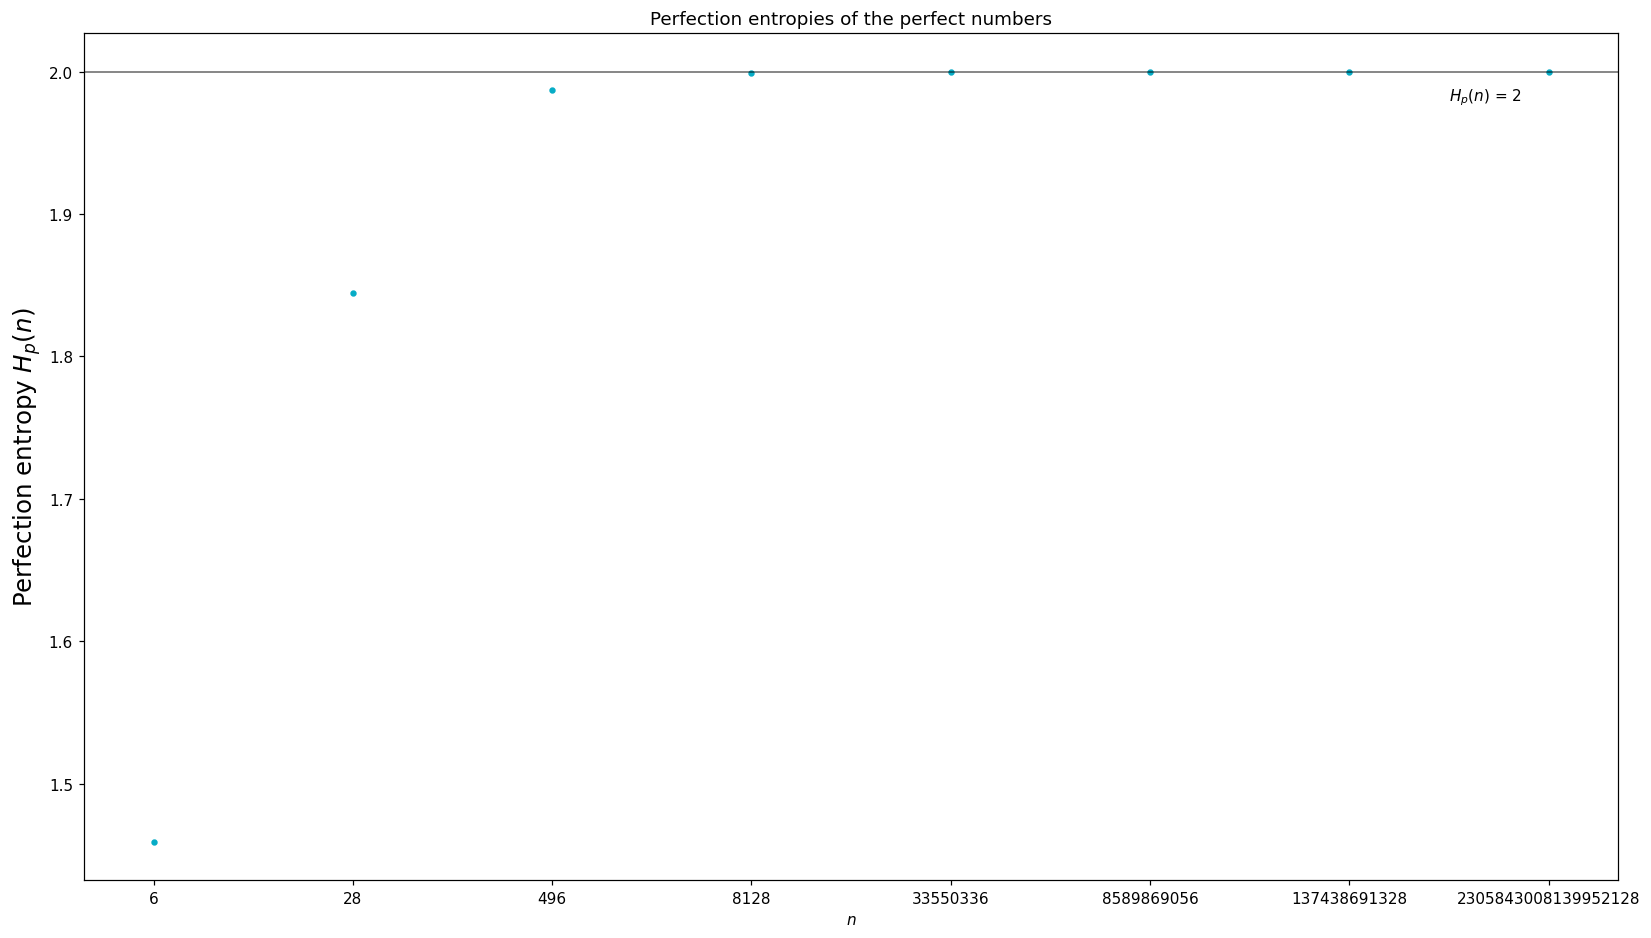

In [ ]:
H = [nf.perfection_entropy(n)[0][0] for n in nd.PERFECTS[:8]]
x = range(len(H))

plt.figure(figsize=(18, 10), dpi=110)
plt.scatter(x, H, s=10, color=cmap[3])
plt.xticks(x, nd.PERFECTS[:8])
plt.axhline(2, lw=1, color="k", alpha=0.6)

# Labels
plt.xlabel("$n$")
plt.ylabel(r"Perfection entropy $H_p(n)$", fontsize=16)
plt.title("Perfection entropies of the perfect numbers")
plt.annotate("$H_p(n)$ = 2", xy=(6.5, 1.98))

# plt.savefig("./Perfection_entropies_perfect_only.png", bbox_inches="tight")
plt.show()

Only primitive pseudoperfect numbers were generated above. The following interpolates numbers within the first $k$ (= `stop`) non-primitive pseudoperfect integers that are not in the data already.

You can repeatedly by increase the `stop` parameter to interpolate $k_{i+1} - k_i$ more values (with $k_0 = 0$). That is, with an initial value of `stop` $= k_0 = 100,$ a hundred new values will be interpolated, and setting stop $= k_1 = 106$ afterwards will interpolate an additional $106 - 100 = 6$  values,

In [ ]:
# 
all_entropies = perfection_data_builder(
    filename='test', mode='e', stop=500, primitive_only=False, interpolate=True)

File saved to ./test.txt


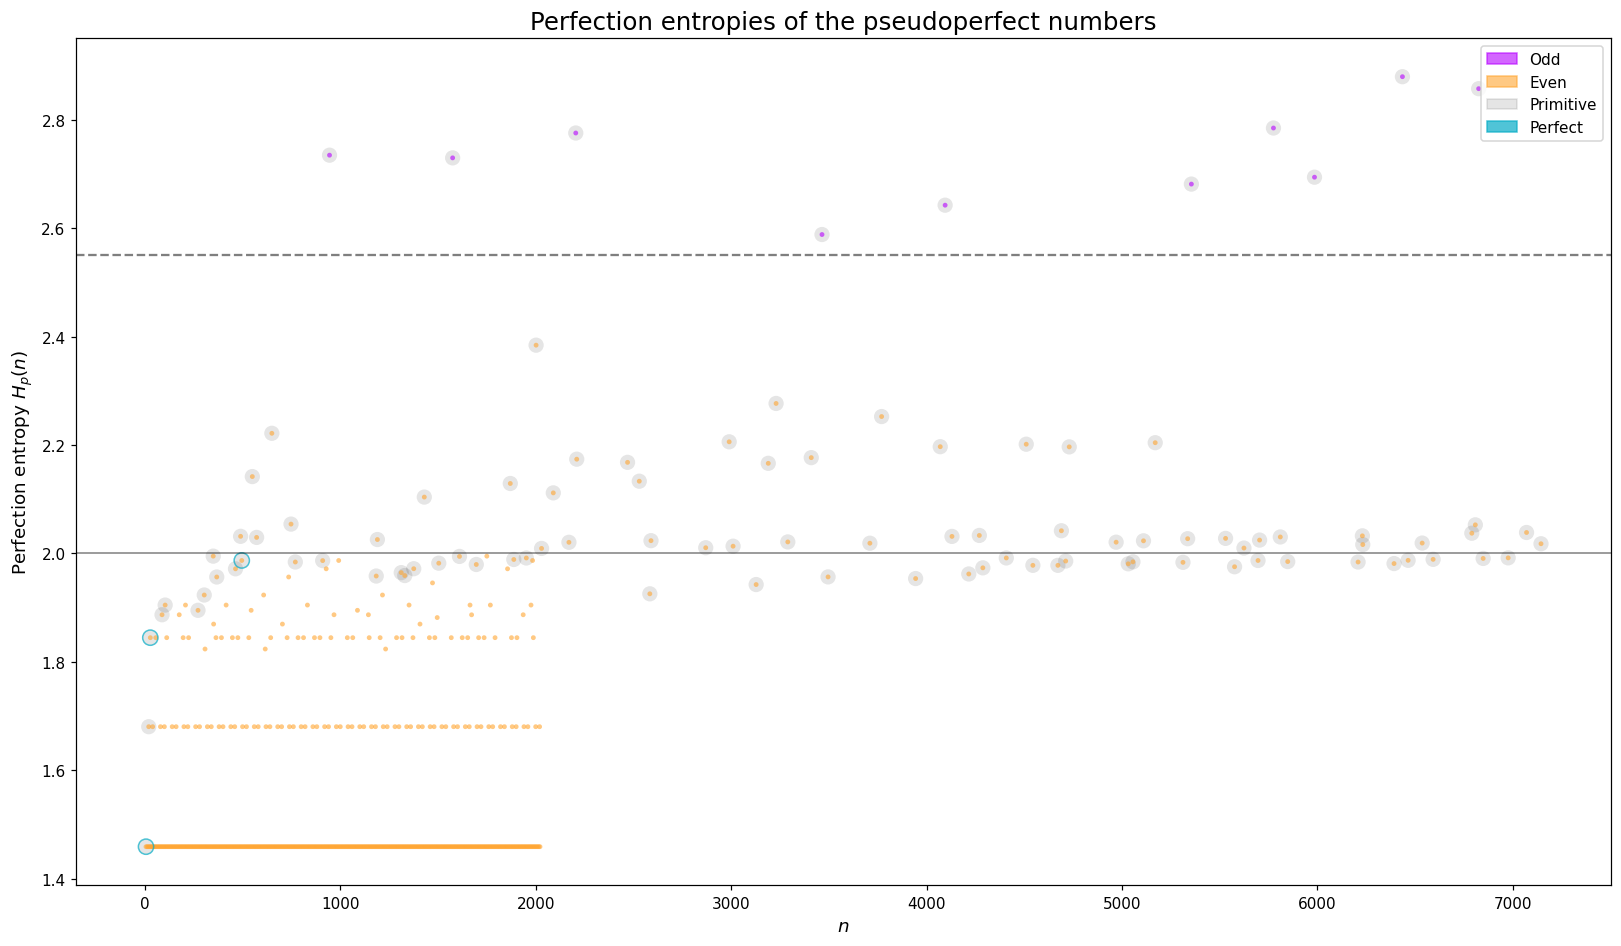

In [ ]:
# Get perfection entropies for plotting
if type(all_entropies) == list:
    x_1 = np.array([p[0] for p in all_entropies])
    y_1 = np.array([p[1] for p in all_entropies])
else:
    x_1 = np.array(list(all_entropies.keys()))
    y_1 = np.array([item[0][0] for item in list(all_entropies.values())])

# Extract primitive pseudos for highlighting
x_2 = x_1[np.isin(x_1, nd.PRIMITIVES)]
y_2 = y_1[np.isin(x_1, nd.PRIMITIVES)]

x_3 = x_1[np.isin(x_1, nd.PERFECTS)]
y_3 = y_1[np.isin(x_1, nd.PERFECTS)]

# Create distinct, colour-blind accessible colourmap
cmap = cc.m_glasbey_bw_minc_20_minl_30.colors[:8]

# Create colourmap to indicate parity
par_cols = [cmap[5] if n % 2 == 0 else cmap[2] for n in x_1]

# Plotting
plt.figure(figsize=(18, 10), dpi=110)
# Plot primitive pseudoperfect numbers
plt.scatter(x_2, y_2, color="k", s=100, edgecolor="none", alpha=0.1)
# Plot pseudoperfect numbers
plt.scatter(x_1, y_1, color=par_cols, s=10, edgecolor="none", alpha=0.6)
# Plot perfect numbers
plt.scatter(x_3, y_3, color="none", s=100, edgecolor=cmap[3], alpha=0.7, linewidth=1)
# Plot asymptote of perfect numbers
plt.axhline(2, color="k", linewidth=1, alpha=0.5, label="$H_p(n)$ = 2")
# Plot classifying line
plt.axhline(2.55, color="k", linestyle="--", alpha=0.5, label="$H_p(n)$ = 2.55")

# Labels
plt.xlabel("$n$", fontsize=12)
plt.ylabel(r"Perfection entropy $H_p(n)$", fontsize=12)
plt.title("Perfection entropies of the pseudoperfect numbers", fontsize=16)
plt.annotate("$H_p(n)$ = 2.55", xy=(39_500, 2.51))
plt.annotate("$H_p(n)$ = 2", xy=(40_500, 1.96))


# Define the proxy artists for the legend
odd_patch = mpatches.Patch(color=cmap[2], label="Odd", alpha=0.6)
even_patch = mpatches.Patch(color=cmap[5], label="Even", alpha=0.6)
prim_patch = mpatches.Patch(color="k", label="Primitive", alpha=0.1)
perf_patch = mpatches.Patch(color=cmap[3], label="Perfect", alpha=0.7)

# Add legend
plt.legend(handles=[odd_patch, even_patch, prim_patch, perf_patch])
# plt.savefig("./Perfection_entropies.png", bbox_inches="tight")
plt.show()